### Background
Due to multiple cyber attacks recently, many reddit posts which were 3 months and older were taken offline as their data were held hostage and copies were deleted. As the management team had decided to not give in to the demands of the hackers, the original data were not recovered. Luckily, the IT team has managed to recover the data partially with informations such as the title, selftext and other informations. Unfortunately, those data recovered did not have the subreddit name, url and links that would provide identifications to those posts.


### Problem Statement
Being a data scientist in Reddit, you made a suggestion to your manager that perhaps the subreddit name could be inferred/predicted from the remaining information recovered through modeling. As a proof of concept, you have been tasked by your manager to:
- Use the latest 3 months of data, complete with subreddit name, from 2 random subreddits 
- Determine how accurate is the suggested approach in identifying the reddit posts
    - Target goal is to achieve at least 90% accuracy

### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

### Function Definition

In [3]:
def plot_term_chart(data, text_feature, ngram_range=(1,1), stop_words='english'):
    # Create subplots with 1 by 2
    fig, ax = plt.subplots(figsize = (12,15), nrows=1, ncols=2)
    fig.tight_layout(pad=6)
    
    # Set color palette
    color_palette = {'LinusTechTips': 'darkorange', 'TrashTaste': 'purple'}
    
    # Count Vectorizer
    # Instantiate
    cvec = CountVectorizer(stop_words=stop_words, ngram_range=ngram_range, max_features=50)
    
    # Fit and transform data
    cvec.fit(data[text_feature])
    data_vec = cvec.transform(data[text_feature])
    data_vec_pd = pd.DataFrame(data_vec.toarray(), columns=cvec.get_feature_names())
    
    # Add subreddit column
    data_vec_pd['subreddit'] = data['subreddit']
    
    # Groupby, melt dataframe and sort by descending order using delta to create barplot comparison
    temp = data_vec_pd.groupby('subreddit').sum().T
    #temp['delta'] = abs(temp['LinusTechTips'] - temp['TrashTaste'])
    temp['delta'] = temp['LinusTechTips'] - temp['TrashTaste']
    temp.sort_values(by='delta',ascending=False, inplace=True)
    temp_melt = temp[['LinusTechTips', 'TrashTaste']].melt(ignore_index=False)
    sns.barplot(y=temp_melt.index, x=temp_melt['value'], hue=temp_melt['subreddit'], palette=color_palette, ax=ax[0])
    ax[0].set_title('Count Vectorizer Top 50 Terms', fontweight = 'bold', fontsize=15)
    
    # TF-IDF Vectorizer
    # Instantiate
    tvec = TfidfVectorizer(stop_words=stop_words, ngram_range=ngram_range, max_features=50)
    
    # Fit and transform data
    tvec.fit(data[text_feature])
    data_vec = tvec.transform(data[text_feature])
    data_vec_pd = pd.DataFrame(data_vec.toarray(), columns=tvec.get_feature_names())
    
    # Add subreddit column
    data_vec_pd['subreddit'] = data['subreddit']
    
    # Groupby, melt dataframe and sort by descending order using delta to create barplot comparison
    temp = data_vec_pd.groupby('subreddit').sum().T
    #temp['delta'] = abs(temp['LinusTechTips'] - temp['TrashTaste'])
    temp['delta'] = temp['LinusTechTips'] - temp['TrashTaste']
    temp.sort_values(by='delta',ascending=False, inplace=True)
    temp_melt = temp[['LinusTechTips', 'TrashTaste']].melt(ignore_index=False)
    sns.barplot(y=temp_melt.index, x=temp_melt['value'], hue=temp_melt['subreddit'], palette=color_palette, ax=ax[1])
    ax[1].set_title('TF-IDF Vectorizer Top 50 Terms', fontweight = 'bold', fontsize=15)
    

### Load Data

In [4]:
linustech = pd.read_csv('../data/linustechtips.csv')
trashtaste = pd.read_csv('../data/trashtaste.csv')
data = pd.concat([linustech, trashtaste], ignore_index=True)
data.drop('Unnamed: 0', axis = 'columns', inplace=True)

### Clean Data

In [5]:
data.head()

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,author_patreon_flair,...,gallery_data,is_gallery,media_metadata,author_flair_template_id,author_flair_text_color,poll_data,author_flair_background_color,author_cakeday,distinguished,banned_by
0,[],False,jakze13,NaN,[],NaN,text,t2_45ruwko5,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],False,SpeedconG,NaN,[],NaN,text,t2_60tn1a31,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],False,Fab-Buns5166,NaN,[],NaN,text,t2_jbr5sgus,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],False,dishitnuts,NaN,[],NaN,text,t2_9vizihuc,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[],False,gekke_gijt,NaN,[],NaN,text,t2_4bb6ae0s,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Data has 85 columns and 4200 rows
data.shape

(4200, 85)

In [7]:
# Check Ratio of labels udner subreddit
data['subreddit'].value_counts(normalize=True)

TrashTaste       0.5
LinusTechTips    0.5
Name: subreddit, dtype: float64

In [8]:
# 3 types of data type: boolean, object/string, numeric
data.dtypes.unique()

array([dtype('O'), dtype('bool'), dtype('int64'), dtype('float64')],
      dtype=object)

In [9]:
# Check datatype of each features
features_obj=[]
features_bool=[]
features_num=[]
for col in data.columns:
    if data[col].dtypes == 'O':
        features_obj.append(col)
    elif data[col].dtypes == 'bool':
        features_bool.append(col)
    else:
        features_num.append(col)
        

#### Dropping features that provide the subreddit name or ID directly or indirectly

Dropping full_link, permalink and subreddit_id as they provide clear hints in distingushing the 2 subreddits.

In [10]:
data[['full_link', 'permalink', 'subreddit_id']]

,full_link,permalink,subreddit_id
0,https://www.reddit.com/r/LinusTechTips/comment...,/r/LinusTechTips/comments/sups9k/cant_get_cpu_...,t5_2v5ru
1,https://www.reddit.com/r/LinusTechTips/comment...,/r/LinusTechTips/comments/suneh4/linus_was_thi...,t5_2v5ru
2,https://www.reddit.com/r/LinusTechTips/comment...,/r/LinusTechTips/comments/sumpbk/blue_screen/,t5_2v5ru
3,https://www.reddit.com/r/LinusTechTips/comment...,/r/LinusTechTips/comments/sulhel/i_need_help_a...,t5_2v5ru
4,https://www.reddit.com/r/LinusTechTips/comment...,/r/LinusTechTips/comments/sukkji/creepy_linus_...,t5_2v5ru
...,...,...,...
4195,https://www.reddit.com/r/TrashTaste/comments/s...,/r/TrashTaste/comments/sfdtws/the_audacity_of_...,t5_2p976a
4196,https://www.reddit.com/r/TrashTaste/comments/s...,/r/TrashTaste/comments/sfdtbz/garnt_should_rea...,t5_2p976a
4197,https://www.reddit.com/r/TrashTaste/comments/s...,/r/TrashTaste/comments/sfdnnh/chris_abroad_in_...,t5_2p976a
4198,https://www.reddit.com/r/TrashTaste/comments/s...,/r/TrashTaste/comments/sfdk75/its_your_boi_chr...,t5_2p976a


In [11]:
data.drop(columns=['full_link', 'permalink', 'subreddit_id'], inplace = True)

#### Checking features with low percentage of null values

As the 8 rows that had null values are posts which were deleted and can longer be access on the website, these submissions were dropped from the data.

In [12]:
# Get features with less than 5% missing data
temp = data.isnull().sum()/data.shape[0]
temp[temp<0.05]

all_awardings              0.000000
allow_live_comments        0.000000
author                     0.000000
author_flair_richtext      0.001905
author_flair_type          0.001905
author_fullname            0.001905
author_is_blocked          0.000000
author_patreon_flair       0.001905
author_premium             0.001905
awarders                   0.000000
can_mod_post               0.000000
contest_mode               0.000000
created_utc                0.000000
domain                     0.000000
gildings                   0.000000
id                         0.000000
is_created_from_ads_ui     0.000000
is_crosspostable           0.000000
is_meta                    0.000000
is_original_content        0.000000
is_reddit_media_domain     0.000000
is_robot_indexable         0.000000
is_self                    0.000000
is_video                   0.000000
link_flair_css_class       0.031190
link_flair_richtext        0.000000
link_flair_text            0.031190
link_flair_text_color      0

In [13]:
data[data['author_flair_richtext'].isnull()]

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_is_blocked,author_patreon_flair,...,gallery_data,is_gallery,media_metadata,author_flair_template_id,author_flair_text_color,poll_data,author_flair_background_color,author_cakeday,distinguished,banned_by
338,[],False,[deleted],NaN,NaN,NaN,NaN,NaN,False,NaN,...,NaN,NaN,NaN,NaN,dark,NaN,NaN,NaN,NaN,NaN
502,[],False,[deleted],NaN,NaN,NaN,NaN,NaN,False,NaN,...,NaN,NaN,NaN,NaN,dark,NaN,NaN,NaN,NaN,NaN
1315,[],False,[deleted],NaN,NaN,NaN,NaN,NaN,False,NaN,...,NaN,NaN,NaN,NaN,dark,NaN,NaN,NaN,NaN,NaN
2672,[],False,[deleted],NaN,NaN,NaN,NaN,NaN,False,NaN,...,NaN,NaN,NaN,NaN,dark,NaN,NaN,NaN,NaN,NaN
3034,[],False,[deleted],NaN,NaN,NaN,NaN,NaN,False,NaN,...,NaN,NaN,NaN,NaN,dark,NaN,NaN,NaN,NaN,NaN
3149,[],False,[deleted],NaN,NaN,NaN,NaN,NaN,False,NaN,...,NaN,NaN,NaN,NaN,dark,NaN,NaN,NaN,NaN,moderators
3443,[],False,[deleted],NaN,NaN,NaN,NaN,NaN,False,NaN,...,NaN,NaN,NaN,NaN,dark,NaN,NaN,NaN,NaN,NaN
3840,[],False,[deleted],NaN,NaN,NaN,NaN,NaN,False,NaN,...,NaN,NaN,NaN,NaN,dark,NaN,NaN,NaN,NaN,NaN


In [14]:
# Dropping rows whereby the 'author_flair_richtext' is NA
data.dropna(subset=['author_flair_richtext'], inplace=True)

#### Droppping features which only has 1 or less label

Dropping features that only has 0 or 1 unique values as they would not be useful in determining which subreddit each submission comes from.

In [15]:
# Check how many features that has unique values less than or equal to 1
temp = data.nunique().sort_values(ascending=True)
temp[temp<=1]

banned_by                 0
author_cakeday            1
is_gallery                1
treatment_tags            1
total_awards_received     1
suggested_sort            1
subreddit_type            1
distinguished             1
num_crossposts            1
media_only                1
locked                    1
link_flair_text_color     1
is_original_content       1
is_meta                   1
is_created_from_ads_ui    1
gildings                  1
all_awardings             1
pinned                    1
awarders                  1
author_is_blocked         1
author_flair_css_class    1
author_patreon_flair      1
contest_mode              1
can_mod_post              1
dtype: int64

In [16]:
# Drop columns where there are only 1 or less unique value for the predictor
data.drop(columns=temp[temp<=1].index, inplace=True)

#### Update features remaining

In [17]:
# Check datatype of each features
features_obj=[]
features_bool=[]
features_num=[]
for col in data.columns:
    if data[col].dtypes == 'O':
        features_obj.append(col)
    elif data[col].dtypes == 'bool':
        features_bool.append(col)
    else:
        features_num.append(col)

#### Fill all missing data from object features as empty string

In [18]:
for feature in features_obj:
    data[feature].fillna('', inplace=True)

In [19]:
# Since we are not using thumbnail_height and thumbnail width, these rows are not drop
data.isnull().sum()

allow_live_comments                 0
author                              0
author_flair_richtext               0
author_flair_text                   0
author_flair_type                   0
author_fullname                     0
author_premium                      0
created_utc                         0
domain                              0
id                                  0
is_crosspostable                    0
is_reddit_media_domain              0
is_robot_indexable                  0
is_self                             0
is_video                            0
link_flair_background_color         0
link_flair_css_class                0
link_flair_richtext                 0
link_flair_template_id              0
link_flair_text                     0
link_flair_type                     0
no_follow                           0
num_comments                        0
over_18                             0
parent_whitelist_status             0
pwls                                0
retrieved_on

#### Removing rows with [removed] or [deleted] in selftext

To remove posts with [removed] or [deleted] in selftext as those posts were either deleted by author, moderator or reddit. They might be spam posts or not adhering to the community guidelines and might not represent the kind of post allowed on the subreddit.

In [20]:
# Dropping rows with [deleted] or [removed] in selftext
data.drop(index=data[data['selftext'].str.contains('\[removed\]|\[deleted\]')].index, inplace=True)

#### Converting epoch (in seconds) to UTC date and time and calculate the time delta between each post

To convert the epoch time which are in seconds to human readable UTC date-time format, year, month, day, hour, minute and second to calculate the time delta between each post for each subreddit.

In [21]:
data['created_datetime'] = pd.to_datetime(data['created_utc'], unit='s')
data['created_year'] = pd.DatetimeIndex(data['created_datetime']).year
data['created_month'] = pd.DatetimeIndex(data['created_datetime']).month
data['created_day'] = pd.DatetimeIndex(data['created_datetime']).day
data['created_hour'] = pd.DatetimeIndex(data['created_datetime']).hour
data['created_minute'] = pd.DatetimeIndex(data['created_datetime']).minute
data['created_second'] = pd.DatetimeIndex(data['created_datetime']).second

In [22]:
# Checking that data is converted correctly
data[['created_datetime', 'created_year', 'created_month', 'created_day', 'created_hour', 'created_minute', 'created_second']]

,created_datetime,created_year,created_month,created_day,created_hour,created_minute,created_second
0,2022-02-17 14:14:06,2022,2,17,14,14,6
1,2022-02-17 12:12:54,2022,2,17,12,12,54
2,2022-02-17 11:32:13,2022,2,17,11,32,13
3,2022-02-17 10:14:42,2022,2,17,10,14,42
4,2022-02-17 09:12:08,2022,2,17,9,12,8
...,...,...,...,...,...,...,...
4195,2022-01-29 08:35:09,2022,1,29,8,35,9
4196,2022-01-29 08:33:53,2022,1,29,8,33,53
4197,2022-01-29 08:22:54,2022,1,29,8,22,54
4198,2022-01-29 08:16:09,2022,1,29,8,16,9


In [23]:
# Calculating the time between posts in each subreddit
data.sort_values(by=['subreddit', 'created_datetime'], ascending=False, inplace=True, ignore_index=True)
for i in range(data.shape[0]-1):
    if data.loc[i, 'subreddit'] == data.loc[i+1, 'subreddit']:
        data.loc[i, 'time_btw_post'] = data.loc[i, 'created_datetime'] - data.loc[i+1, 'created_datetime']
    else:
        data.loc[i, 'time_btw_post'] = data[data['subreddit']==data.loc[i, 'subreddit']]['time_btw_post'].mean()
    data.loc[data.shape[0]-1, 'time_btw_post'] = data[data['subreddit']==data.loc[data.shape[0]-1, 'subreddit']]['time_btw_post'].mean()

In [24]:
# Converts to time between post to minutes
data['time_btw_post_(mins)'] = data['time_btw_post'] / np.timedelta64(1, 'm')

### EDA

#### Title Common Terms
Generally both subreddits do not have very high overlap for those high frequency occurring words.
For LinusTechTips, common terms are linus, pc, help, ltt and gpu while for TrashTaste, they are connor, garnt, chris, taste and joey which are mainly the hosts' or guest's name.

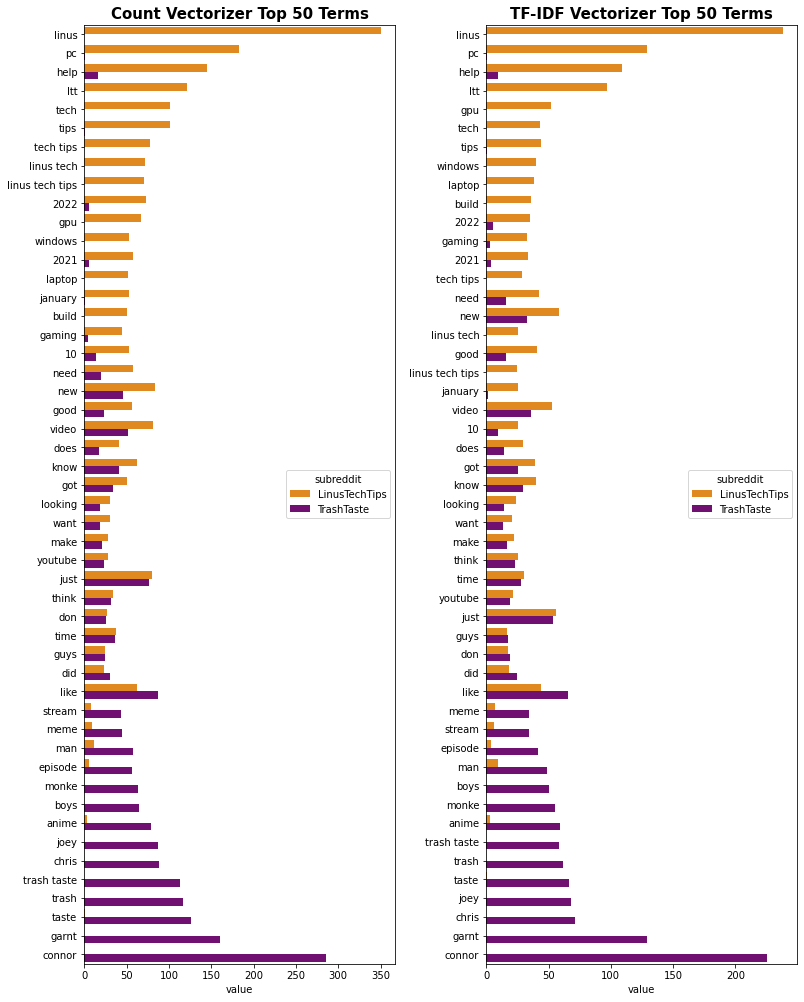

In [25]:
# Check top 50 terms for title
plot_term_chart(data, 'title', ngram_range=(1,3))

#### Selftext Common Terms
In general selftext is more commonly used in LinusTechTips and the words used greatly help to differentiate LinusTechTips from TrashTaste as seen in the chart below where the value is significantly higher for LinusTechTips as comapared to TrashTaste. Some examples of terms that are more common and unique for LinusTechTips are 'pc', 'just', like', 'new', 'cpu' and 'gpu'.

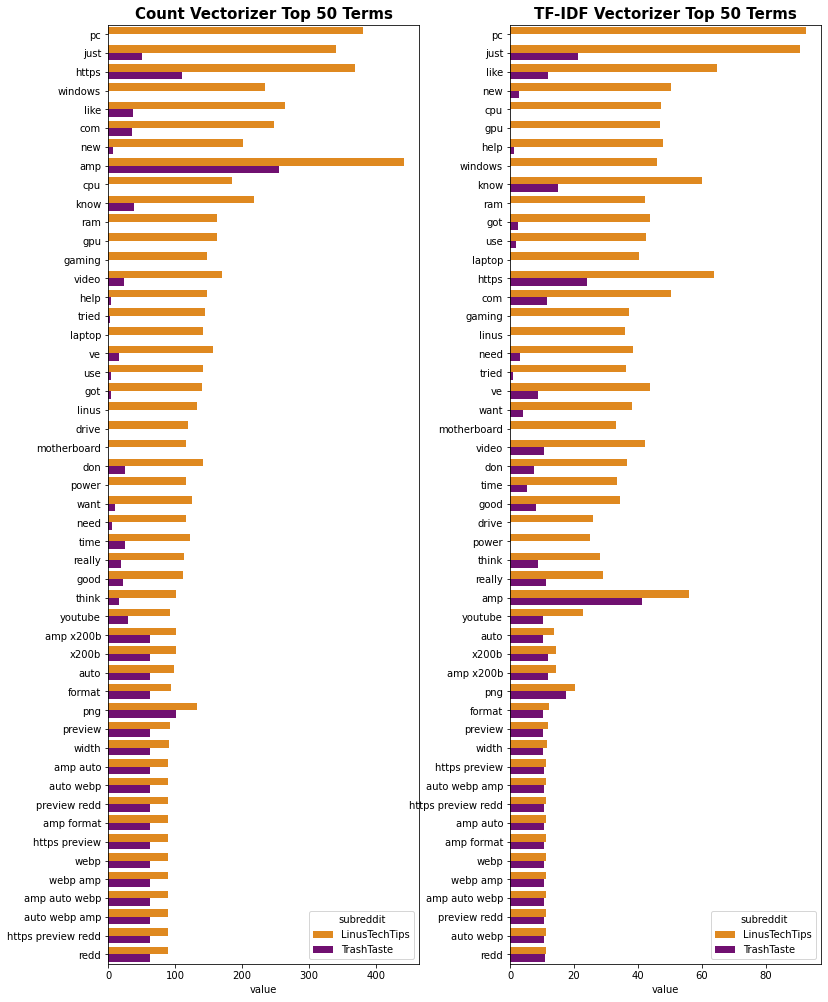

In [26]:
# Check top 50 terms for selftext
plot_term_chart(data, 'selftext', ngram_range=(1,3))

#### Any Overlapping Authors
There are no overlap between the 2 subreddits in terms of the authors when comparing the top 50 authors.

In [27]:
# Make into DataFrame
temp = pd.DataFrame(data.groupby(['author_fullname', 'subreddit']).count()['author'].sort_values(ascending=False))
temp2 = pd.DataFrame({'author_fullname': [i[0] for i in temp.index], 'subreddit': [i[1] for i in temp.index], 'count': [i for i in temp['author']]})

Text(0, 0.5, 'Author Full Name')

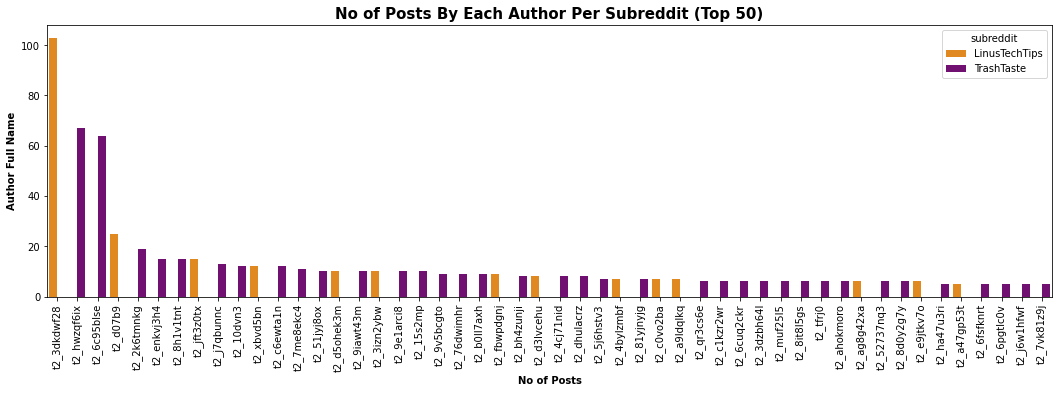

In [28]:
plt.figure(figsize=(18,5))
sns.barplot(y='count', x='author_fullname', data=temp2.head(50), hue='subreddit', palette={'LinusTechTips': 'darkorange', 'TrashTaste': 'purple'})
plt.title('No of Posts By Each Author Per Subreddit (Top 50)', fontsize=15, fontweight ='bold')
plt.xlabel('No of Posts', fontweight='bold')
plt.xticks(rotation=90)
plt.ylabel('Author Full Name', fontweight='bold')

#### Does Subreddit Affects the Type of Ads Shown?

Usually the content of the posts would affect the kind of ads shown on a website as no advertiser would like to associate themselves with a post that might be inappropriate. From the analysis, majority of posts from LinusTechTips are eligible for any ads as they are more family-friendly while TrashTaste, on the other hand, are only eligible for some ads. Both subreddits have some posts that are allowed to have NSFW (Not Suitable for Work) content.

Text(0, 0.5, 'Subreddit, Types of Ads Eligible')

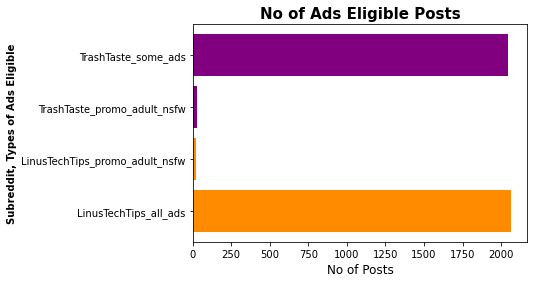

In [29]:
# To determine if the subreddit affects the type of ads
temp = data[['whitelist_status', 'subreddit', 'wls']].groupby(['subreddit', 'whitelist_status'])['wls'].count()
plt.barh(y=[subreddit + "_" + ads for subreddit, ads in temp.index], width=temp, 
         color=['darkorange', 'darkorange', 'purple', 'purple'])
plt.title('No of Ads Eligible Posts', fontweight = 'bold', fontsize=15)
plt.xlabel('No of Posts', fontsize=12)
plt.ylabel('Subreddit, Types of Ads Eligible', fontweight = 'bold', fontsize=10)

#### Determining how 'link_flair_text' changes with subreddit
Most posts for LinusTechTips has tags such as image, discussion, tech, post, video, question and wan. Whereas for TrashTaste, the common tags are meme, screeshot, clip, tweet and art.

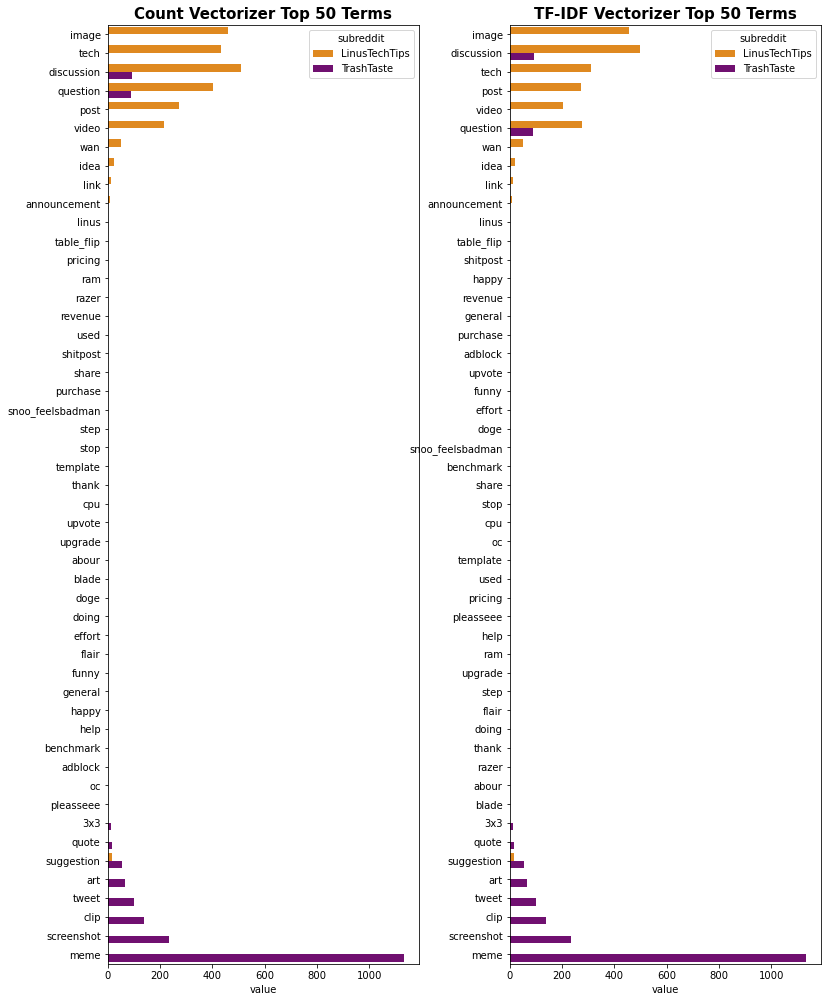

In [30]:
plot_term_chart(data, 'link_flair_text', ngram_range=(1,1))

#### Determining how 'author_flair_richtext' changes with subreddit
Only posts from LinustechTips utilises 'author_flair_richtext' and the usage rate is very low. It is probably not a good predictor for majority of the posts.

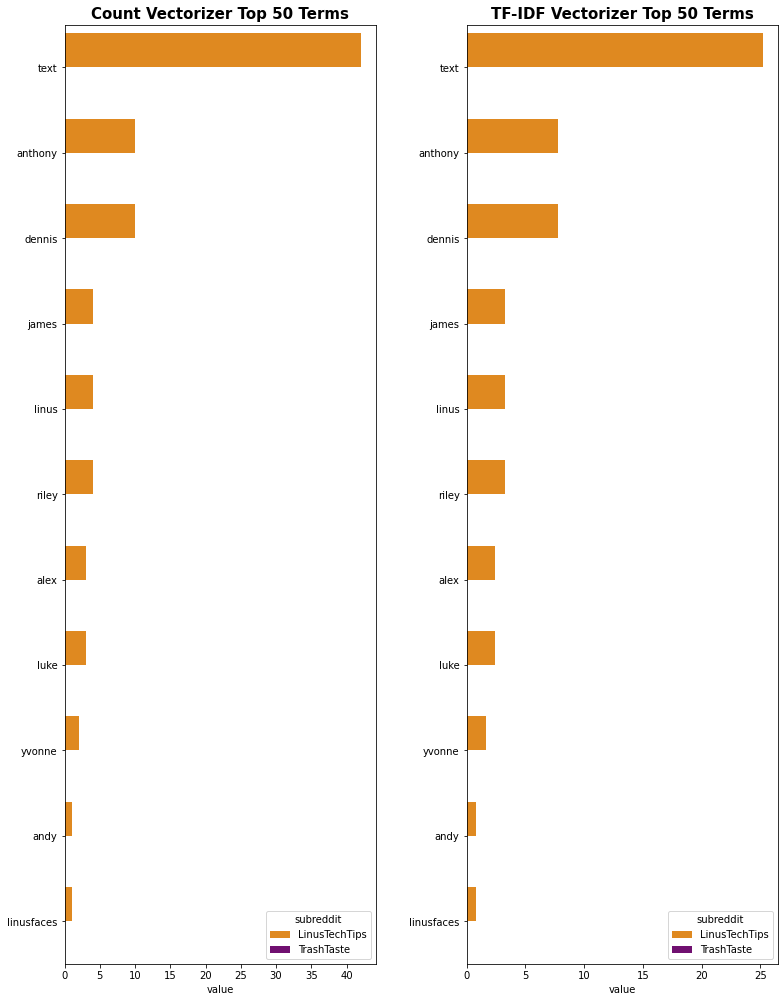

In [31]:
plot_term_chart(data, 'author_flair_richtext', ngram_range=(1,1))

#### How time between each post varies by subreddit
From the boxplot, it can be observed that redditors from TrashTaste usually post more frequently as compared to LinusTechTips. However, because it takes a long time for this parameter to be calculated for a large dataset, this is not going to be used in the model.

<AxesSubplot:xlabel='subreddit', ylabel='time_btw_post_(mins)'>

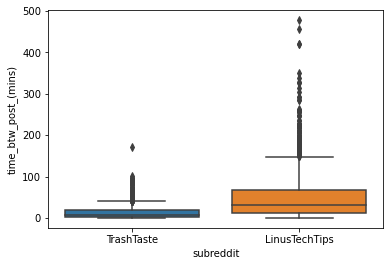

In [32]:
sns.boxplot(x=data['subreddit'], y=data['time_btw_post_(mins)'])